# Two Class (Binary) Logistic Regression in Pytorch
> This is a practice notebook for implementing a two class logistic regression model in PyTorch. We will start by generating some synthetic data and then build an end-to-end pipeline to train a model. We will also see two ways to implement logistic regression models.

- toc: true 
- badges: true
- comments: true
- categories: [pytorch]
- keyword: [ml, dl, logistic, regression, pytorch]
- image: images/copied_from_nb/images/2022-10-11-pytorch-two-class-logistic-regression.jpeg

![](images/2022-10-11-pytorch-two-class-logistic-regression.jpeg)

## Introduction

In this notebook, we will train a logistic regression model using PyTorch. Given below is the summary of the steps followed in this notebook.
* Create a synthetic binary class dataset
* Split the data into `Train` and `Validation` datasets. Then convert them into mini-batches using PyTorch `DataLoader` class
* Create a Neural Net model configuration, an SGD optimizer, and a loss function
* Create a pipeline that will train the model on given data and update the weights based on the loss 
* Compare the results with a scikit-learn logistic regression model

## Environment
This notebook is prepared with Google Colab.

In [1]:
#collapse
from platform import python_version
import sklearn, numpy, matplotlib, pandas, torch

print("python==" + python_version())
print("sklearn==" + sklearn.__version__)
print("numpy==" + numpy.__version__)
print("torch==" + torch.__version__)
print("matplotlib==" + matplotlib.__version__)

python==3.7.14
sklearn==1.0.2
numpy==1.21.6
torch==1.12.1+cu113
matplotlib==3.2.2


## Credits
This notebook takes inspiration from the book "Deep Learning with PyTorch Step-by-Step" by "Daniel Voigt Godoy". You can get the book from its website: [pytorchstepbystep](https://pytorchstepbystep.com/). In addition, the GitHub repository for this book has valuable notebooks and can be used independently: [github.com/dvgodoy/PyTorchStepByStep](https://github.com/dvgodoy/PyTorchStepByStep). Parts of the code you see in this notebook are taken from [chapter 3 notebook](https://colab.research.google.com/github/dvgodoy/PyTorchStepByStep/blob/master/Chapter03.ipynb) of the same book.

## Generate synthetic data

In this section, we will generate some data representing two interleaving half-circles using [sklearn.datasets.make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). The purpose of `make_moons` function is defined as

> Make two interleaving half circles. A simple toy dataset to visualize clustering and classification algorithms ... It generates 2d binary classification datasets that are challenging to certain algorithms (e.g. centroid-based clustering or linear classification), including optional Gaussian noise.

In [2]:
## 
# Synthetic data generation
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

# split data into train-validation sets using 80-20 ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

# standardize data
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

Let's view the first ten elements of the generated data. Note that `X_train` has two features (2 columns), and `y_train` has 0,1 classes as labels.

In [3]:
X_train[:10], y_train[:10]

(array([[-0.59635346, -0.51713419],
        [ 0.3937561 , -1.35813138],
        [ 1.33167696, -1.16636502],
        [-1.52208256, -0.33314461],
        [-1.20280449,  0.64649722],
        [-0.65443973,  0.48658224],
        [ 1.00612744, -1.81018492],
        [-0.28996374, -1.5477782 ],
        [ 0.03349394, -0.65113935],
        [-0.94744907,  0.76650095]]), array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0]))

Let's plot our generated data to see how it looks.

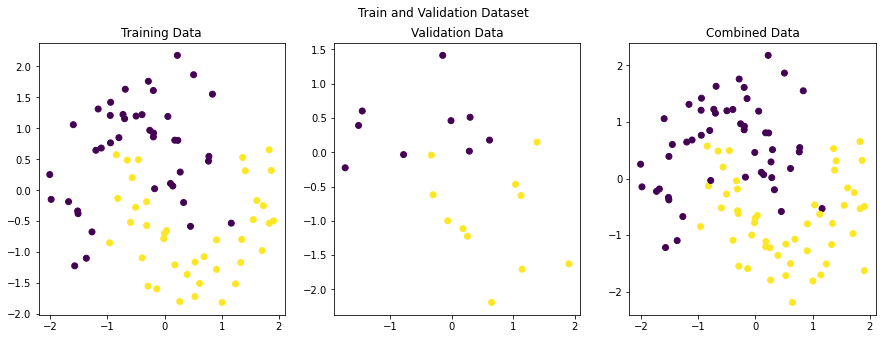

In [4]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(15,5))
figure.suptitle('Train and Validation Dataset')

axes[0].set_title('Training Data')
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

axes[1].set_title('Validation Data')
axes[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val)

axes[2].set_title('Combined Data')
axes[2].scatter(X_train[:, 0], X_train[:, 1], c=y_train)
axes[2].scatter(X_val[:, 0], X_val[:, 1], c=y_val)
plt.show()

## Load generated data into PyTorch Dataset and DataLoader class

In this section, we will load our data in PyTorch helper classes Dataset and DataLoader. PyTorch documentation defines them as: [see [basics/data_tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)]

> Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.


For this, we first need to convert NumPy data arrays to PyTorch tensors.

In [5]:
import torch

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

Now load the tensors into Dataset and DataLoader class. PyTorch Dataset is a helper class that converts data and labels into a list of tuples. DataLoader is another helper class to create batches from Dataset tuples. `batch_size` means the number of tuples we want in a single batch. We have used 16 here since our data is small. So each fetch from DataLoader will give us a list of 16 tuples.

In [6]:
## 
# Load tensors into Dataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Define a class to implement training, validation, and mini-batch processing pipeline

In this section we will implement a class that encapsulates all the usual steps required in training a PyTorch model. This way we can focus more on the model architecture and performance, and less concerned about the boilerplate training loop. Important parts of this class are
* `__init__`: Class constructor to define the main actors in a training cycle including model, optimizer, loss function, training and validation DataLoaders
* `_make_train_step_fn`: Training pipeline is usually called "training step" which includes the following steps
    1. Compute our model's predicted output - the forward pass
    2. Compute the loss
    3. Compute gradients i.e., find the direction and scale to update the weights to reduce the loss
    4. Update weight parameters using gradients and the learning rate
* `_make_val_step_fn`: Validation pipeline is usually called the "validation step" which includes the following steps
    1. Compute our model's predicted output - the forward pass
    2. Compute the loss
    3. Note that during validation, we are only concerned about the loss, i.e., how well our model performs on the validation dataset. Therefore, we don't use it to calculate the gradients.
* `_mini_batch`: It defines the steps to process a single minibatch in a helper function. For a mini-batch processing, we want to
    1. Get the next batch of data and labels (x, y) from the DataLoader iterator
    2. Perform a step on the batch. A step can be either training or validation
    3. Compute the average batch loss
* `train`: Execute training and validation steps for given number of epoch
* `predict`: Make a prediction from model on provided data

In [7]:
import numpy as np
import datetime
from torch.utils.tensorboard import SummaryWriter

class DeepLearningPipeline(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## Create model configuration

In this section, we will configure the model for training, define a loss function, and an optimizer to update the weights.

There are two ways in which we can define our logistic classifier.

**First Approach:** A model with *a single linear layer and no activation function* at the end. In this case, the output from the model will not be probabilities, and the loss function we use is `nn.BCEWithLogitsLoss`. In this case, our model is very similar to a linear regression model but with a different loss function. 'BCEWithLogitsLoss' is a variant of Binary Cross Entropy loss function (nn.BCELoss) and is defined as 'numerically more stable' [see docs [torch.nn.BCEWithLogitsLoss.html](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)]

> This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.


In this approach, we train a model without 'Sigmoid' layer. But at the time of classification, we pass the output from the model (called as logits) to 'Sigmoid' function to get class probabilities.

**Second Approach:** Here we have an activation function (nn.Sigmoid) after the Linear layer. In this case, we have probabilities as an output. The loss function we use in this case is [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

Let's try both these approaches.

### Logistic regression model without Sigmoid layer

In [8]:
##
# Logistic model configuration without Sigmoid layer
import torch.nn as nn
import torch.optim as optim

lr = 0.1

torch.manual_seed(42)
model_1 = nn.Sequential()
model_1.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer_1 = optim.SGD(model_1.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn_1 = nn.BCEWithLogitsLoss()

Now let's train our model for 100 epochs.

In [9]:
n_epochs = 100

dlp_1 = DeepLearningPipeline(model_1, loss_fn_1, optimizer_1)
dlp_1.set_loaders(train_loader, val_loader)
dlp_1.train(n_epochs)

Let's see how our training and validation loss looks like.

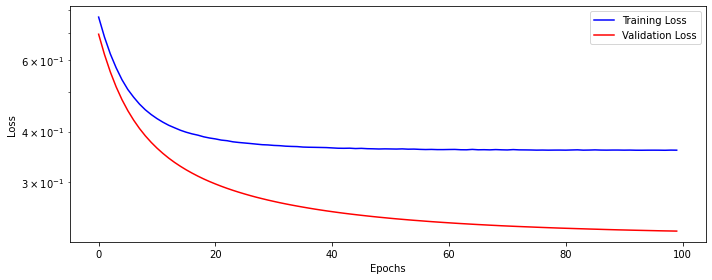

In [10]:
fig = dlp_1.plot_losses()

Let's also print the weights learned by our model. Note that there are two weights in the linear layer, as there were two features (or columns) for our X_train data.

In [11]:
print(model_1.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])), ('linear.bias', tensor([-0.0591]))])


Let's also create a confusion matrix for our validation data. Note that here we have used `torch.sigmoid` to convert the output from the model into probabilities.

In [12]:
from sklearn.metrics import confusion_matrix

logits_val = dlp_1.predict(X_val)
logits_val_tensor = torch.from_numpy(logits_val)
probabilities_val = torch.sigmoid(logits_val_tensor).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

Let's also print the output model for five validation data points. Again, remember that the output is logits, not probabilities.

In [13]:
logits_val[:5]

array([[-0.37522304],
       [ 0.7390274 ],
       [-2.5800889 ],
       [-0.93623203],
       [-1.6819004 ]], dtype=float32)

### Logistic regression model with Sigmoid layer
Now let's again create our model, but this time 'Sigmoid' layer is attached at the end.

In [14]:
##
# Logistic model configuration with Sigmoid layer
model_2 = nn.Sequential()
model_2.add_module('linear', nn.Linear(2, 1))
model_2.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_2 = optim.SGD(model_2.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn_2 = nn.BCELoss(reduction='mean')

In [15]:
n_epochs = 100

dlp_2 = DeepLearningPipeline(model_2, loss_fn_2, optimizer_2)
dlp_2.set_loaders(train_loader, val_loader)
dlp_2.train(n_epochs)

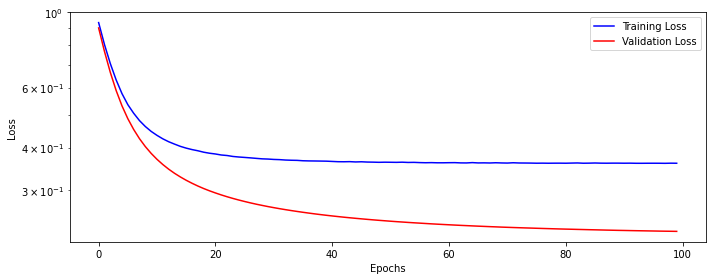

In [16]:
fig = dlp_2.plot_losses()

Let's print the learned weights. They are slightly different from the last model.

In [17]:
print(model_2.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1794, -1.8716]])), ('linear.bias', tensor([-0.0604]))])


Let's also create a confusion matrix for comparison. Note that the results are same as from the first model.

In [18]:
from sklearn.metrics import confusion_matrix

probabilities_val = dlp_2.predict(X_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

Let's also print the model output for five validation data points. Each output shows the probability of a point belonging to class 0 or 1. The points with a probability greater than 0.5 are put into class 1, and the remaining are placed into class 0. So from the below output

* `0.4070907` --> class 0
* `0.6768992` --> class 1
* `0.0704094` --> class 0

In [19]:
probabilities_val[:5]

array([0.4070907 , 0.6768992 , 0.07040942, 0.28118652, 0.15702702],
      dtype=float32)

### Comparison with Scikit-learn LogisticRegression model

Let's also compare our model with sklearn logistic regression and see how our neural net model compares to it.



In [20]:
##
# Comparison with sklearn logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Let's see the weights learned by the model.

In [21]:
logreg.coef_ , logreg.intercept_

(array([[ 1.03955962, -1.60876812]]), array([-0.05857131]))

Let's create a confusion matrix for comparison. Note that the results are identical.

In [22]:
predictions = logreg.predict(X_val)
probabilities_val = logreg.predict_proba(X_val)
cm_thresh50 = confusion_matrix(y_val, predictions)
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

Let's also print the output model for five validation data points. Again, remember the output is probabilities, and the sum of each row is 1.

Note that the scikit-learn model output has two columns. Both show the probabilities of a point for class 0 or 1 (left to right). PyTorch model only outputs the probability of a point belonging to class 1 (right column). Since the sum of probabilities is equal to 1, we can find the other class probability (for binary classifiers only) if we have one class probability.

In [23]:
probabilities_val[:5]

array([[0.58380158, 0.41619842],
       [0.34949557, 0.65050443],
       [0.90582984, 0.09417016],
       [0.69290104, 0.30709896],
       [0.81695121, 0.18304879]])

## Why classification is called logistic **regression**

What classification has to do with regression, and why do we call it logistic regression? Remember that our binary classifier model has a linear layer with a `logistic function` at the end. A logistic function is an S-shaped curve function [wiki/Logistic_function](https://en.wikipedia.org/wiki/Logistic_function).

![logistic_model.png](images/2022-10-11-pytorch-two-class-logistic-regression/logistic_model.png)

*Image taken from [PyTorchStepByStep](https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/images/logistic_model.png) GitHub repository*.

When doing `linear regression`, we are trying to find a line that best fits our data points. We measure our error by finding the distance between each data point and our fitted line. If the distance between points and the line is minimum, we say we have found the best line that fits our data. Otherwise, we wiggle it up and down slowly till our errors are minimum.

In the case of `logistic regression`, we are also fitting a line on our data such that it can separate them into distinct categories. Points on one side of the line belong to class A, and points on the other side belong to class B. We usually call this line a **decision boundary**.

How do we measure our error in this case? We can measure error by counting how many points we have correctly classified. But just using a count is a very rough measurement. Because there can be multiple angles on which we can place a line in data and still be able to classify the points by the exact count. There should be a better way to tell us that a particular line angle is better than all others. For this, we use probabilities from a sigmoid (logistic) function. This helps us to capture the errors in a better way.

If a data point is on one side of the line (decision boundary) but is further away from it, we say it has a high probability of being in class A. If a point is close to the line, we say it has a low probability of being in class A. And we can extend this logic for points on the other side of the line. If a data point is on the other side of the decision boundary but close to the line, we give it a low probability of being in class B. And if a point is on the other side but farther away, we give it a high probability of being in class B. 

> *During training, we are trying to find a line that maximizes the certainty of data points for being in their correct classes.*

Let's create a plot to see how our decision boundary looks like for our trained models.

In [68]:
#collapse
def plot_decision_boundary(model, X_train, X_val):
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Check if model is PyTorch model
    if type(model) == torch.nn.modules.container.Sequential:
        # get predictions
        logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float())
        # check if model's last layer is Linear, then apply Sigmoid on predictions to get probabilities
        if type(model[-1]) == torch.nn.modules.linear.Linear:
            logits = torch.sigmoid(logits).squeeze()
        
        logits = logits.detach().cpu().numpy().reshape(xx.shape)
    else: # Sklean model
        logits = logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        logits = logits[:,1]
        logits = logits.reshape(xx.shape)

    fig = plt.figure(figsize=(14,7))
    fig.suptitle('Plot Model Decision Boundary')

    # Plot 1
    ax1 = plt.subplot(1,3,1)
    ax1.set_title('In 2D Plane')
    # ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    ax1.scatter(X_val[:, 0], X_val[:, 1], c=y_val)
    ax1.contour(xx, yy, logits, levels=[0.5], cmap="Greys", vmin=0, vmax=1)

    # Plot 2
    ax2 = plt.subplot(1,3,2, projection='3d')
    ax2.set_title('In 3D Plane - View 1')
    # ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    ax2.scatter(X_val[:, 0], X_val[:, 1], c=y_val)
    ax2.plot_surface(xx, yy, logits, color='lightgreen')
    ax2.view_init(10, 10)

    # Plot 3
    ax3 = plt.subplot(1,3,3, projection='3d')
    ax3.set_title('3D Plane - View 2')
    # ax3.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    ax3.scatter(X_val[:, 0], X_val[:, 1], c=y_val)
    ax3.plot_surface(xx, yy, logits, color='lightgreen')
    
    plt.show()

### Decision boundary for logistic regression model without Sigmoid
Let's view the decision boundary for the first model we build. That model has only a Linear layer and no Sigmoid function at the end. Notice that the decision boundary is a straight line (or a plane in 3D) that cuts the data in a way that maximizes the certainty of data for being in one class or the other.

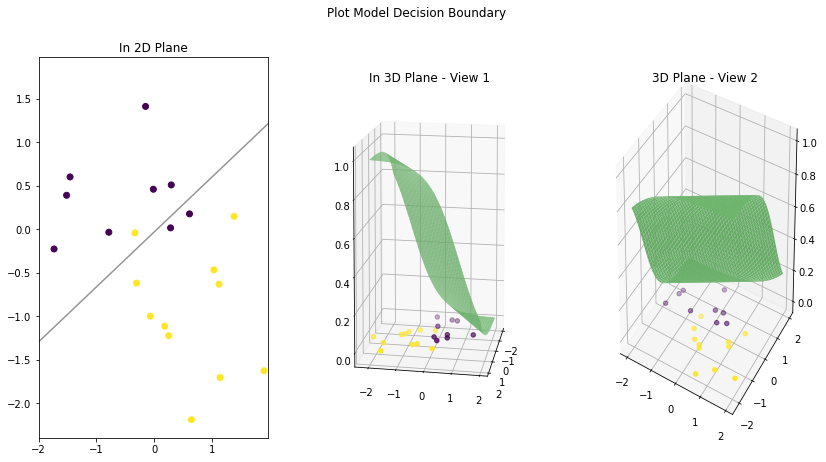

In [69]:
plot_decision_boundary(model_1, X_train, X_val)

### Decision boundary of a logistic regression model with Sigmoid
Let's draw the decision boundary for our classification model with Sigmoid as the last layer. 

Note that it is not a line this time when we view the decision boundary in 3D space. The 3D plane is more like an S-shaped curve. Because now our model output is probabilities coming out of a logistic function. Think of it as an extra step that is now added to the output of the first model (no sigmoid). The points on the extreme right side of the first model linear plane are given the lowest probabilities (almost zero). And as we move to the left, the possibilities *gradually* increase with 0.5 at the middle and highest when we reach the extreme left (almost 1).

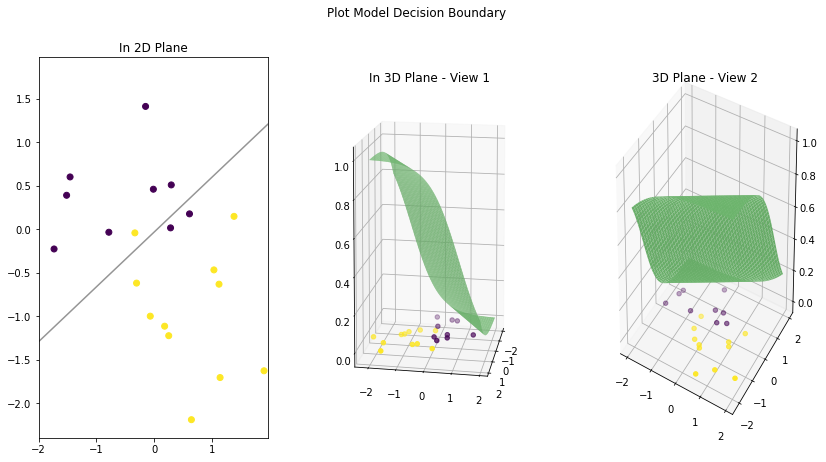

In [70]:
plot_decision_boundary(model_2, X_train, X_val)

### Decision boundary of sklearn logistic regression model

Let's now plot the same for sklearn model. The plot is similar to the last model. 

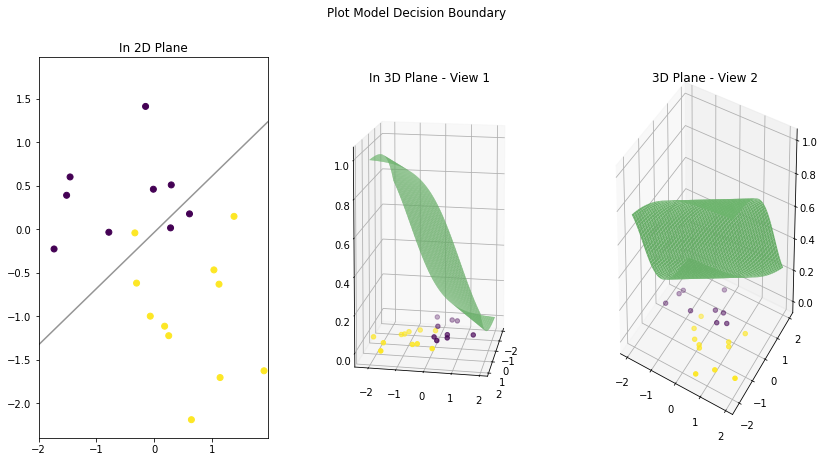

In [71]:
plot_decision_boundary(logreg, X_train, X_val)

## Can we do better?
We have seen that our models' decision boundaries are linear (a line), and on the validation set they misclassify 3 points (two purple dots below the line and one yellow dot above the line). What if we can bend our decision boundary a little? Will it be able to better capture the classes in validation data? Let's test it.

We introduce **non-linearity** to our decision boundary by placing a non-linear activation function between our neural net layers. Let's create another model but this time use two hidden layers with a non-linear activation function (ReLU) in between them.

In [72]:
##
# Logistic model configuration with two hidden layers and ReLU in between
# No Sigmoid layer at the end
model_3 = nn.Sequential()
model_3.add_module('linear1', nn.Linear(2, 10))
model_3.add_module('activation1', nn.ReLU())
model_3.add_module('linear2', nn.Linear(10, 1))

# Defines a SGD optimizer to update the parameters
optimizer_3 = optim.SGD(model_3.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn_3 = nn.BCEWithLogitsLoss()

This time I have trained the model a little longer (200 epochs) as we have more weights to learn from the data.

In [73]:
n_epochs = 200

dlp_3 = DeepLearningPipeline(model_3, loss_fn_3, optimizer_3)
dlp_3.set_loaders(train_loader, val_loader)
dlp_3.train(n_epochs)

Let's view model's performance.

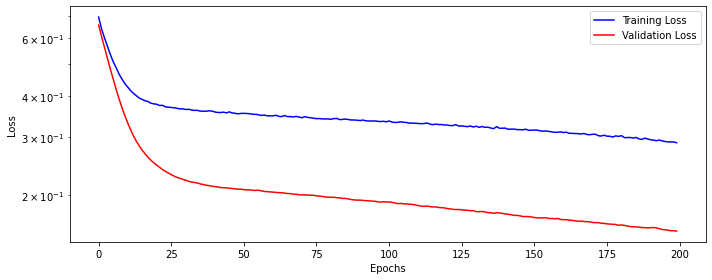

In [74]:
fig = dlp_3.plot_losses()

Let's print the learned model weights. They are many now.

In [75]:
print(model_3.state_dict())

OrderedDict([('linear1.weight', tensor([[-0.2820, -0.1793],
        [-0.3769,  0.9521],
        [ 0.3869, -0.2811],
        [ 0.7851,  0.1663],
        [ 0.5037,  0.0550],
        [ 1.2392, -0.1268],
        [ 1.4645,  0.6353],
        [-0.7931,  0.6277],
        [ 0.6682, -0.7956],
        [ 0.9999, -0.4732]])), ('linear1.bias', tensor([-0.6636,  0.0574,  0.8233, -0.3366,  0.8664, -0.6355,  0.7653,  0.8898,
         0.0732, -0.4389])), ('linear2.weight', tensor([[ 0.1312, -0.6890,  0.7334,  0.6812,  0.6840,  0.9567, -1.4818, -0.9092,
          0.8679,  1.0426]])), ('linear2.bias', tensor([0.4460]))])


Let's create a confusion matrix. Notice that our error has improved, and the model only misclassifies one data point from the validation set.

In [76]:
from sklearn.metrics import confusion_matrix

logits_val_3 = dlp_3.predict(X_val)
logits_val_tensor_3 = torch.from_numpy(logits_val_3)
probabilities_val = torch.sigmoid(logits_val_tensor_3).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 9,  0],
       [ 1, 10]])

Let's plot the model's decision boundary. First, notice that it is not linear and has a bend. This effect is due to placing a non-linear activation function after a linear layer. And, it has correctly captured two purple data points and barely missed a yellow point. 

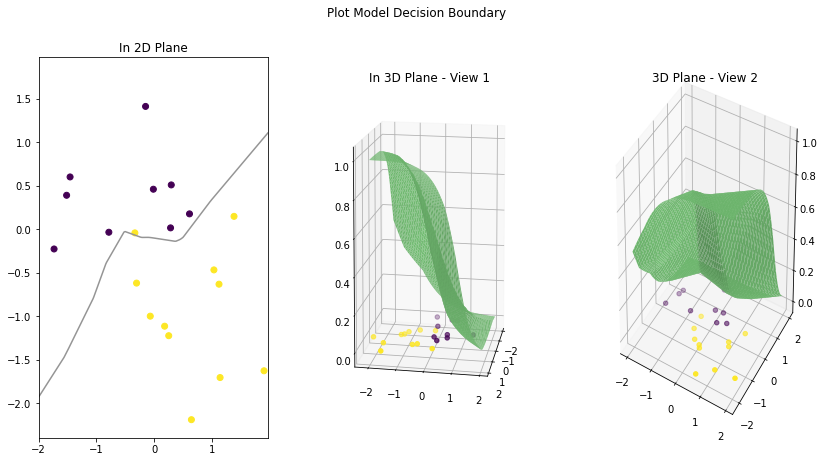

In [77]:
plot_decision_boundary(model_3, X_train, X_val)

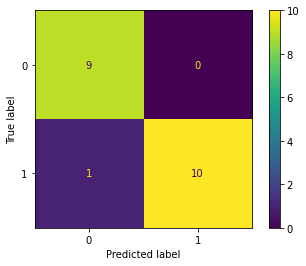

In [79]:
##
# Confusion matrix plot
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thresh50, display_labels=[0,1])
disp.plot()
plt.show()